# Replication Notebook for Figs. 1, 2 and 3

This notebook contains the code and figure for replication of Figs. 1, 2 and 3 in XX. 

Figs. 1, 2 and 3 were generated through R. Please follow the installation instructions provided in README.

## Data loading

Evaluate the following cell to load the data. By default, aggregated data files should have been downloaded in the sub-folder called `data`, relative to the path of the notebook itself. If you downloaded the data to a different location, change the value of the `data_path` variable below.

In [14]:
data_path = 'data/'

dataa = read.table(paste(data_path, "Fig_1_2_3/ng_pulse_fig1_fig3_replication.csv", sep=""),sep=",",header=TRUE)

## Figure 1

__caption__: _Relationship between audience size and news quality by domain. The Pearson correlation is r=0.05, p=0.11._

Warning message:
“Removed 10769 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10769 rows containing missing values (geom_point).”

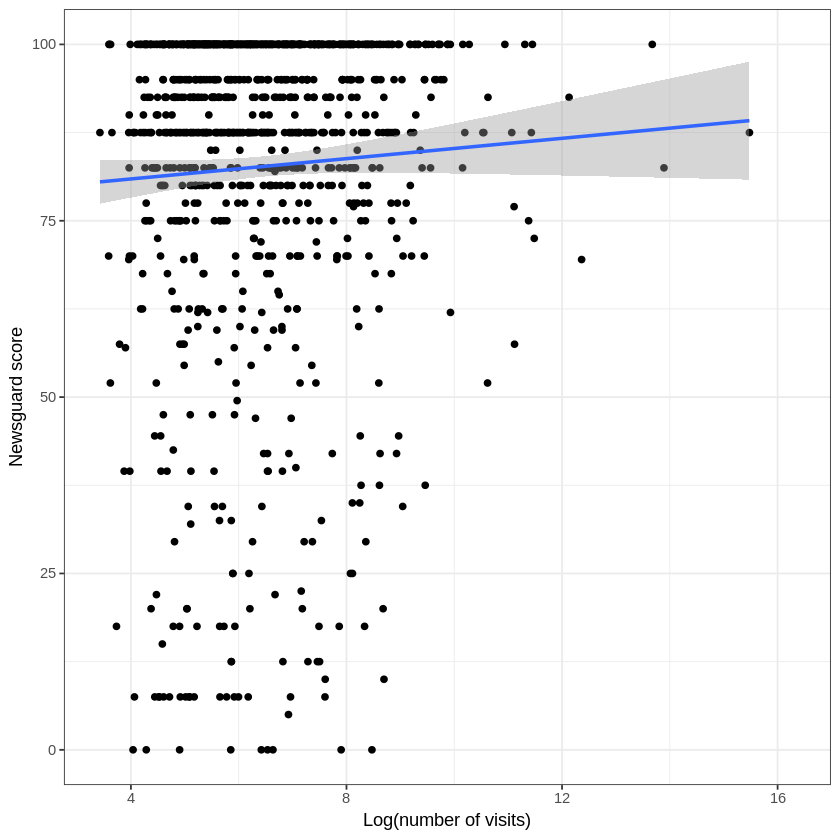

In [15]:
library(ggplot2)
library(magrittr)
dataa %>% 
    ggplot(aes(x = log_n, y = Score)) + 
    geom_point() + 
    geom_smooth(method = "lm", formula = y~x) + 
    theme_bw() + 
    xlab("Log(number of visits)") + ylab("Newsguard score")

## Figure 2 (Left)

__caption__: _For individual users. Average audience partisanship versus variance. Domains with a news quality score are shaded in blue (where darker shades equal lower scores). Domains with no score are plotted in gray._

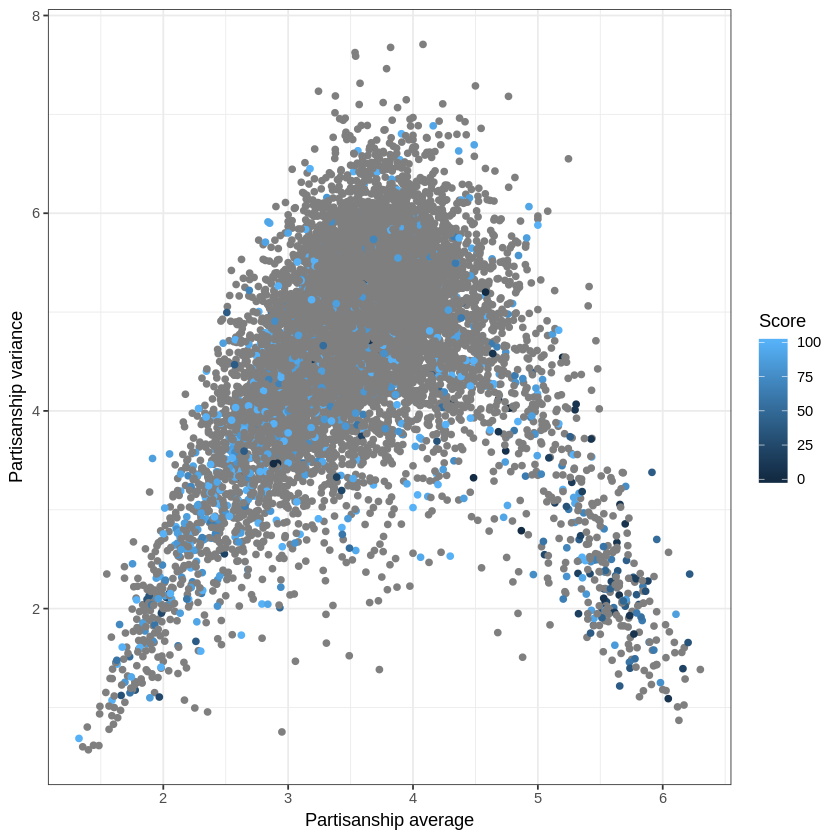

In [16]:
library(ggplot2)
library(magrittr)
dataa %>%
ggplot(aes(x = visitor_avg, y = visitor_var, color = Score)) +
geom_point() +
theme_bw() +
xlab("Partisanship average") +
ylab("Partisanship variance")

## Figure 2 (Right)

__caption__: _Weighted by pageviews. Average audience partisanship versus variance. Domains with a news quality score are shaded in blue (where darker shades equal lower scores). Domains with no score are plotted in gray._

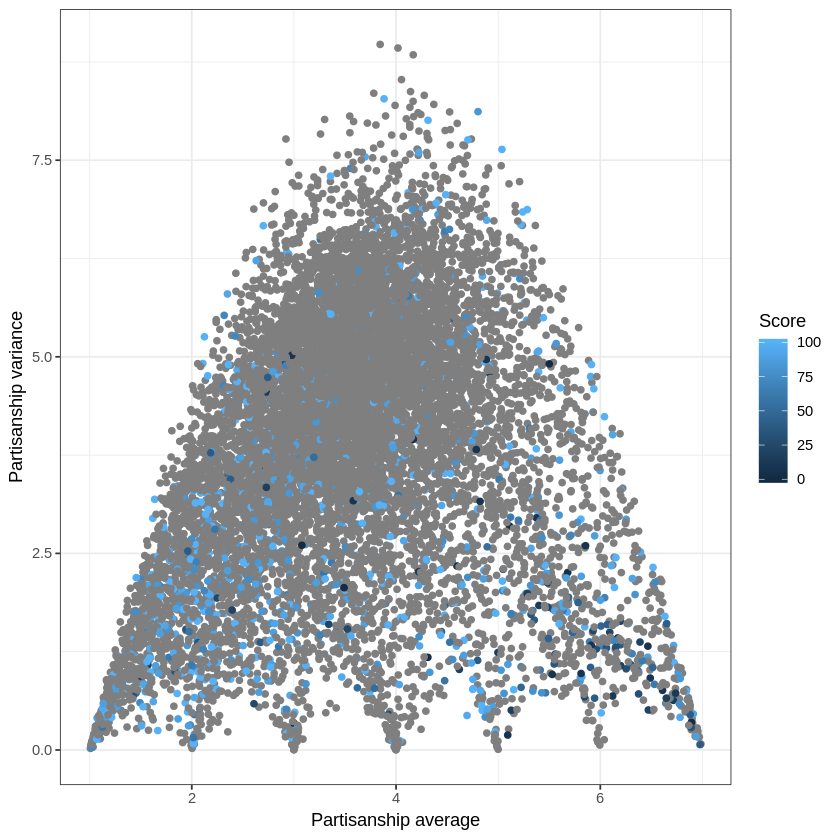

In [17]:
library(ggplot2)
library(magrittr)
dataa %>%
ggplot(aes(x = view_avg, y = pageview_var, color = Score)) +
geom_point() +
theme_bw() +
xlab("Partisanship average") +
ylab("Partisanship variance")

## Figure 2 (Left)

__caption__: _For individual users. Relationship between audience partisan diversity and news quality for websites whose average visitor is a Democrat or a Republican._

Warning message:
“Removed 10703 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10703 rows containing missing values (geom_point).”

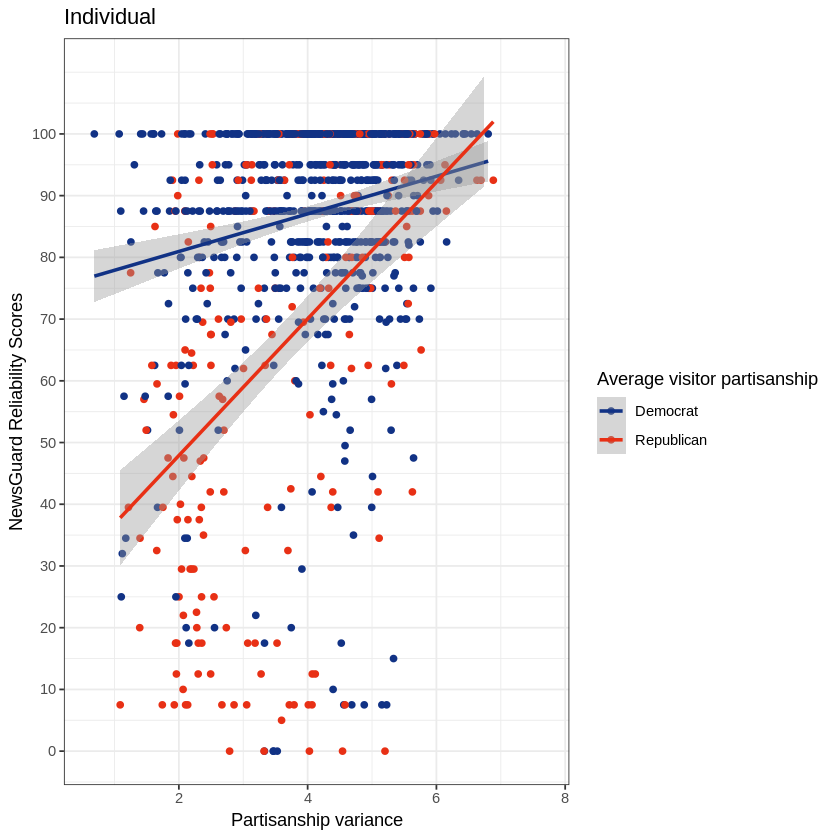

In [30]:
library(tidyverse)
library(magrittr)
dataa %>%
filter(!is.na(is_conservative)) %>%
ggplot(aes(x = visitor_var, y = Score, color = factor(is_conservative))) +
geom_point() +
geom_smooth(method = "lm") +
scale_y_continuous(breaks = seq(0,100, by = 10), limits = c(0,110)) +
theme_bw() +
xlab("Partisanship variance") +
ylab("NewsGuard Reliability Scores") +
ggtitle("Individual") +
scale_color_manual(values = c("#113285", "#E83015"), labels = c("Democrat", "Republican")) +
labs(color = "Average visitor partisanship")

## Figure 2 (Right)

__caption__: _Weighted by pageviews. Relationship between audience partisan diversity and news quality for websites whose average visitor is a Democrat or a Republican._

Warning message:
“Removed 10703 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10703 rows containing missing values (geom_point).”

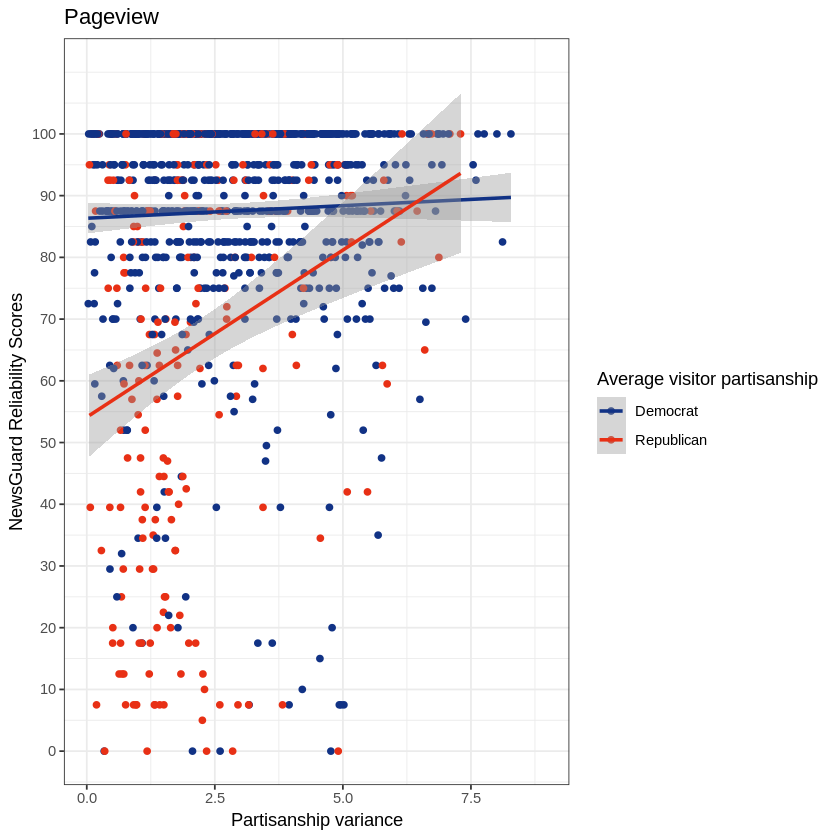

In [31]:
library(tidyverse)
library(magrittr)
dataa %>%
filter(!is.na(is_conservative)) %>%
ggplot(aes(x = pageview_var, y = Score, color = factor(is_conservative))) +
geom_point() +
geom_smooth(method = "lm") +
scale_y_continuous(breaks = seq(0,100, by = 10), limits = c(0,110)) +
theme_bw() +
xlab("Partisanship variance") +
ylab("NewsGuard Reliability Scores") +
ggtitle("Pageview") +
scale_color_manual(values = c("#113285", "#E83015"), labels = c("Democrat", "Republican")) +
labs(color = "Average visitor partisanship")